In [1]:
%load_ext autoreload
%autoreload 2

# Getting started with granite-geospatial-land-surface-temperature

This notebook demonstrates the usage of the granite-geospatial-land-surface-temperature model hosted on Hugging Face for the spatial downscaling of Land Surface Temperature (LST). Along with this getting_started notebook, we include 4 other notebooks which describe:
1. [download_data](https://github.com/ibm-granite/granite-geospatial-land-surface-temperature/blob/main/notebooks/2_download_data.ipynb): How to download HLS L30 and ERA5-Land for new cities

2. [preprocessing_data](https://github.com/ibm-granite/granite-geospatial-land-surface-temperature/blob/main/notebooks/3_preprocess_data.ipynb): Preprocessing of the new data downloaded

3. [introduction_to_LST_Tweening](https://github.com/ibm-granite/granite-geospatial-land-surface-temperature/blob/main/notebooks/4_introduction_to_LST_Tweening.ipynb): Temporal downscaling of LST (Tweening)

4. [tweening_data_preparation](https://github.com/ibm-granite/granite-geospatial-land-surface-temperature/blob/main/notebooks/5_tweening_data_preparation.ipynb): How to prepare a tweening dataset for new data downloaded

The granite-geospatial-LST model is a fine-tuned Earth Observation Foundation Model (EOFM) that predicts LST from Harmonized Landsat and Sentinel-2 (HLS) L30 optical satellite imagery and ERA5-Land near-surface air temperature $(T_{2m})$. Ground truth LST used as target during training was calculated from the HLS L30 optical satellite imagery for 28 cities, representing a diverse set of bio-climatic zones across the globe. You can view the selected cities in the [model card](https://github.com/ibm-granite/granite-geospatial-land-surface-temperature/blob/main/model-card.md). Note that we only use L30 data since Sentinel-2 satellites do not observe thermal radiation.” (Note: We restrict data used for fine-tuning and inference to acquisitions from Landsat only, since Sentinel satellites do not observe thermal radiation)

The fine-tuned LST model can be used to detect the Surface Urban Heat Island (SUHI) effect, which is defined by the higher temperatures experienced in built urban environments as opposed to their surrounding rural landscapes. The detection and characterization of SUHIs are important as the increased heat in the urban areas has several negative impacts on city operations, resource management, human health, and livelihoods.  Even though LST observations can be derived from detctors on satellites such as Landsat, MODIS, and EcoSTRESS, some of these data products and instruments vary in spatial resolution, may have limited temporal coverage, This fine-tuned model is a first step towards leveraging an EOFM to enable the ability to estimate LST maps at high spatial resolution and temporal frequency, which is beneficial for SUHI studies to quantify, detect and characterize SUHIs.     

Please see the [model card](https://github.com/ibm-granite/granite-geospatial-land-surface-temperature/blob/main/model-card.md) for more information on the model development, including the base foundation model. The input data contained 14 layers, 6 HLS band layers [B02-B07], 4 ERA5-Land ${T_2m}$ layers and sine and cosine of the Time-of-Day (TOD) and sine and cosine of the Day-of-Year (DOY) layers. The final model only utilised 7 layers: 6 HLS band layers [B02-B07] and the spatial mean of the ERA5-Land ${T_2m}$ at the time of acquisition. 

This notebook guides the user on the use of the granite-geospatial-LST model for:

1. __Inference:__ The granite-geospatial-LST model is loaded and applied to test examples (data from a city that it hasn't seen during fine-tuning) to produce an estimate of LST.
2. __Evaluate Predictions:__ Evaluate performance of all predictions across different dimensions, including location and over time.

The granite-geospatial-LST model weights are available from the Hugging Face IBM Granite Model Repository (LINK). The required data to complete the experiments in this notebook is available through Zenodo (LINK).

# Setting up your environment

The granite-geospatial-LST model is trained using the [Terratorch framework](https://github.com/IBM/terratorch/). Terratorch simplifies the integration of foundation model backbones into the TorchGeo framework and provides generic LightningDataModules that can be built at runtime. For more information on Terratorch, please refer to the instructions in the [Terratorch Quick Start Guide](https://ibm.github.io/terratorch/quick_start/).

## If running locally

Before running the notebook, make sure you have created a python environment and installed the directory granite-geospatial-LST using:

```
cd granite-geospatial-land-surface-temperature
pip install -e .
```

This will install pytorch and Terratorch for you, amongst a few other libraries.  Run the below cell if using this as a Colab notebook.

## If running on Colab

In [ ]:
import sys
if 'google.colab' in sys.modules:
  # Clone the ibm-granite/granite-geospatial-land-surface-temperature GitHub
  !git clone https://github.com/ibm-granite/granite-geospatial-land-surface-temperature.git
  # Install the package
  !pip install ./granite-geospatial-land-surface-temperature
  # Change to the notebooks directory
  %cd granite-geospatial-land-surface-temperature/notebooks/

## Running the code

In [2]:
import os
import sys
import shutil
import glob
import yaml
import pandas as pd
import numpy as np
import subprocess
from pathlib import Path
sys.path.append("../")

# Third Party
import rioxarray as rio
from lightning.pytorch import Trainer
from terratorch.cli_tools import LightningInferenceModel
import terratorch
from huggingface_hub import hf_hub_download
import matplotlib.pyplot as plt
import tqdm
import tarfile
import urllib
if 'google.colab' in sys.modules:
  import gdown

# First Party
from utils.plotting import plot_results
from utils.plotting import plot_rgb_lst_distribution_scatter
from utils.plotting import plot_box_plot

# Model and data preparation

Let's start with downloading the model checkpoints and configs from HuggingFace:

In [3]:
# Download the model checkpoints, specify the path in local_dir
ckpt_path = hf_hub_download(repo_id="ibm-granite/granite-geospatial-land-surface-temperature", 
                            filename="LST_model.ckpt", 
                            local_dir="../")

# Download the configs, specify path save directory in local_dir
config_path_patches = hf_hub_download(repo_id="ibm-granite/granite-geospatial-land-surface-temperature", 
                                      filename="config.yaml", 
                                      local_dir="../")
config_path_full_tile = hf_hub_download(repo_id="ibm-granite/granite-geospatial-land-surface-temperature", 
                                        filename="config_full_tile.yaml", 
                                        local_dir="../")

LST_model.ckpt:   0%|          | 0.00/2.48G [00:00<?, ?B/s]

config.yaml:   0%|          | 0.00/4.16k [00:00<?, ?B/s]

config_full_tile.yaml:   0%|          | 0.00/4.42k [00:00<?, ?B/s]

Let's continue with downloading the datasets from Zenodo.  We will download two datasets - patched (2.69 GB) and full-tiles  (2.25 GB).  The model was trained on patches of size 224 x 224 from various cities and this format is also used for evaluating the model.  The model can inference on larger full-tile images also, and it's a good way to see the surface urban heat island effect across the full extent of a city.  Validation on the patches will be performed later in the notebook.

In [ ]:
# Specify path to where all data will be downloaded to
data_path = Path("../data")
data_path.mkdir(parents=True, exist_ok=True)

# Download and uncompress full-tile dataset from Zenodo 
dataset_fulltile_path = Path("../data/granite-geospatial-land-surface-temperature-dataset-full-tiles.tar.gz")
if 'google.colab' in sys.modules:
  gdown.download("https://drive.google.com/uc?id=15Ed1AcldcEyH-vaBCmr4I8BSbJoUGmQ9", str(dataset_fulltile_path))
else:
  !wget "https://zenodo.org/records/14034636/files/granite-geospatial-land-surface-temperature-dataset-full-tiles.tar.gz?download=1" -O {str(dataset_fulltile_path)}

!tar -xf {str(dataset_fulltile_path)} --directory {str(data_path)}
inputs_path_full = data_path.joinpath(f"granite-geospatial-land-surface-temperature-dataset-full-tiles/inputs/")
targets_path_full = data_path.joinpath(f"granite-geospatial-land-surface-temperature-dataset-full-tiles/targets/")
predictions_path_full = data_path.joinpath("predictions-full-tiles/")
predictions_path_full.mkdir(parents=True, exist_ok=True)

# Download and uncompress patched dataset from Zenodo 
dataset_patched_path = Path("../data/granite-geospatial-land-surface-temperature-dataset.tar.gz")

if 'google.colab' in sys.modules:
  gdown.download("https://drive.google.com/uc?id=1_pMj9cYVZ8GKdXjFPYMvSqtFVqmxOFrY", str(dataset_patched_path))
else:
  !wget "https://zenodo.org/records/14034636/files/granite-geospatial-land-surface-temperature-dataset.tar.gz?download=1" -O {str(dataset_fulltile_path)}

!tar -xf {str(dataset_patched_path)} --directory {str(data_path)}
inputs_path_patch = data_path.joinpath(f"granite-geospatial-land-surface-temperature-dataset/inputs/")
targets_path_patch = data_path.joinpath(f"granite-geospatial-land-surface-temperature-dataset/targets/")
predictions_path_patch = data_path.joinpath("predictions-patches/")
predictions_path_patch.mkdir(parents=True, exist_ok=True)

# Specify path to where results can be saved
results_path = data_path.joinpath(f"results/")
results_path.mkdir(parents=True, exist_ok=True)

## Run Inference on a couple of cities
For the first step, we use the granite-geospatial-land-surface-temperature model to inference on data from cities that the model hasn't seen during fine-tuning/training.  The data required for these inference examples should have been downloaded in the preceding cells, and saved in the path given by the `data_path` variable.  This inference step essentialy predicts LST at a $30 m$ resolution using the HLS L30 data and a $T_{2m}$ average from ERA5-Land.  We will make use of the `config_full_tile.yaml` config file provided in the `config` folder.

Note:  Running inference might take a couple of minutes if you are using CPU only.

In [8]:
# Run inference
conf = yaml.safe_load(Path(config_path_full_tile).read_text())
data_bands = "[" + ",".join([str(x) for x in conf['data']['init_args']['output_bands']]) + "]"

_ = subprocess.call(['terratorch', 'predict', '-c', config_path_full_tile,
                     '--ckpt_path', str(ckpt_path), 
                     '--predict_output_dir', str(predictions_path_full), 
                     '--data.init_args.predict_data_root', str(inputs_path_full), 
                     '--data.init_args.predict_dataset_bands', data_bands])

# If the above block of code using subprocess.call does not work, use the string stored in run_str to do the inferencing via the CLI.
#run_str = f"terratorch predict -c {config_path_full_tile} --ckpt_path {str(ckpt_path)} --predict_output_dir {str(predictions_path_full)} --data.init_args.predict_data_root {str(inputs_path_full)} --data.init_args.predict_dataset_bands {data_bands}"
#print(run_str)

terratorch predict -c ../config_full_tile.yaml --ckpt_path ../LST_model.ckpt --predict_output_dir ../data/predictions-full-tiles --data.init_args.predict_data_root ../data/granite-geospatial-land-surface-temperature-dataset-full-tiles/inputs --data.init_args.predict_dataset_bands [BLUE,GREEN,RED,NIR_NARROW,SWIR_1,SWIR_2,7]


## Plot results
For the next step, we will plot some of the results obtained from the inference step.  This will include the following images: an RGB color composite from HLS, observed LST, predicted LST, and the error between prediction and observation.  We will plot 3 examples for the city of Baltimore.  The file name has the format of `city`_`country`.`tileID`.`date`.T`timestamp`.  The following files will be used:

1. baltimore_usa.T18SUJ.20160702.T104554 (a summer example)
2. baltimore_usa.T18SUJ.20180708.T104510 (another summer example)
3. baltimore_usa.T18SUJ.20191116.T104623 (a winter example)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96782607..21.95972].


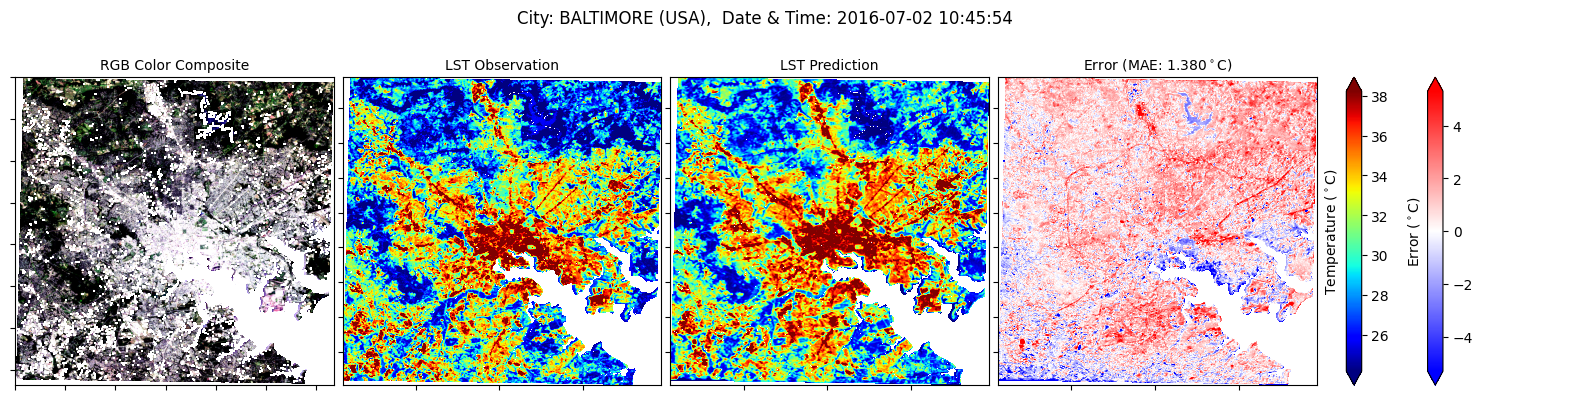

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.85816234..20.069378].


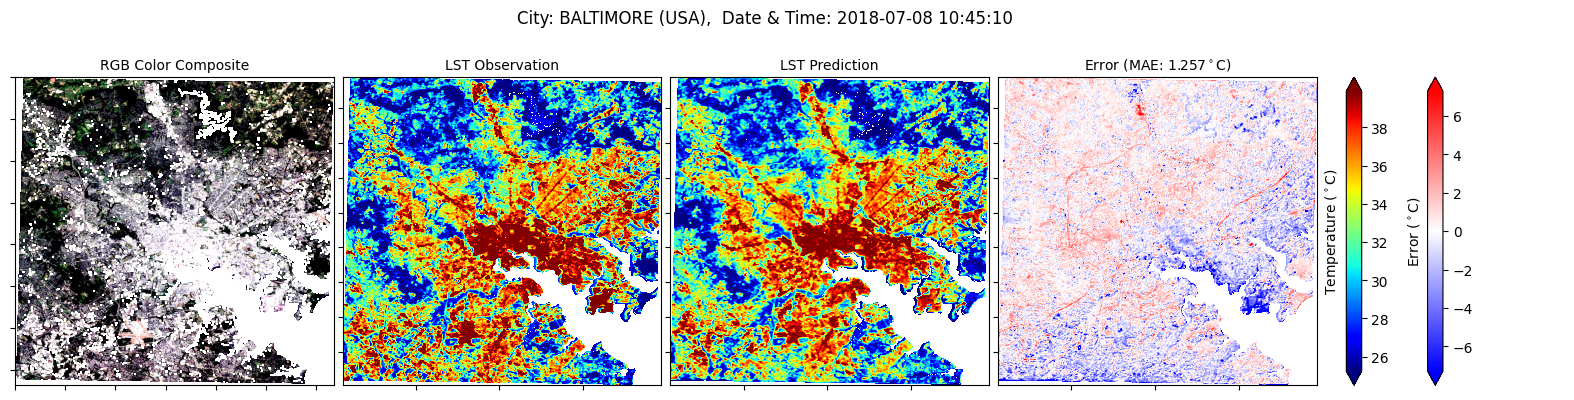

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0026405..50.45858].


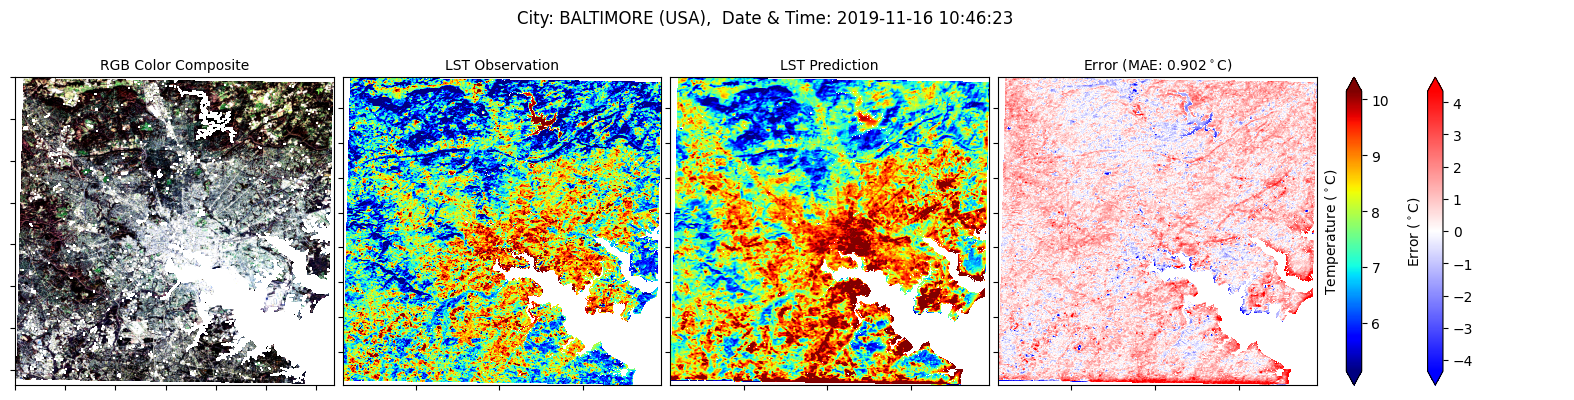

In [5]:
# Plot an example for Baltimore for summer
tile_name = "baltimore_usa.T18SUJ.20160702.T104554" # summer example
plot_results(tile_name, inputs_path_full, targets_path_full, predictions_path_full)

# Plot another example for Baltimore for summer
tile_name = "baltimore_usa.T18SUJ.20180708.T104510" # summer example
plot_results(tile_name, inputs_path_full, targets_path_full, predictions_path_full)

# Plot an example for Baltimore for winter
tile_name = "baltimore_usa.T18SUJ.20191116.T104623" # winter example
plot_results(tile_name, inputs_path_full, targets_path_full, predictions_path_full)

## Run Inference on more cities for evaluation
We will now run inference on a collection of patches downloaded earlier for 6 cities.  These cities are:  Johannesburg (South Africa), Paris (France), Dhaka (Bangladesh), Baltimore (USA), Havana (Cuba), and Porto (Portugal).  We will use the `config.yaml` file provided in the `configs` folder.

Note:  Running inference might take a couple of minutes if you are using CPU only.

In [7]:
# Run inference
conf = yaml.safe_load(Path(config_path_patches).read_text())
data_bands = "[" + ",".join([str(x) for x in conf['data']['init_args']['output_bands']]) + "]"

_ = subprocess.call(['terratorch', 'predict', '-c', config_path_patches,
                     '--ckpt_path', str(ckpt_path), 
                     '--predict_output_dir', str(predictions_path_patch), 
                     '--data.init_args.predict_data_root', str(inputs_path_patch), 
                     '--data.init_args.predict_dataset_bands', data_bands])

# If the above block of code using subprocess.call does not work, use the string stored in run_str to do the inferencing via the CLI.
#run_str = f"terratorch predict -c {str(config_path_patches)} --ckpt_path {str(ckpt_path)} --predict_output_dir {str(predictions_path_patch)} --data.init_args.predict_data_root {str(inputs_path_patch)} --data.init_args.predict_dataset_bands {data_bands}"
#print(run_str)

terratorch predict -c ../config.yaml --ckpt_path ../LST_model.ckpt --predict_output_dir ../data/predictions-patches --data.init_args.predict_data_root ../data/granite-geospatial-land-surface-temperature-dataset/inputs --data.init_args.predict_dataset_bands [BLUE,GREEN,RED,NIR_NARROW,SWIR_1,SWIR_2,7]


## Evaluate on multiple cities
We can now evaluate the model on the 6 cities mentioned above.  Three of these cities (Johannesburg, Paris, and Dhaka) are cities that the model has seen before during fine-tuning, but we use unseen timestamps as a held-out test set, which evaluates the model's ability to generalize over time.  The other cities (Baltimore, Havana and Porto) are locations that the model hasn't seen before and therefore evaluate the model across time and region. 

Note: This code block will take a few minutes to generate the plot as statistics are calculated on each patch and then aggregated per city. 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2413/2413 [02:58<00:00, 13.52it/s]


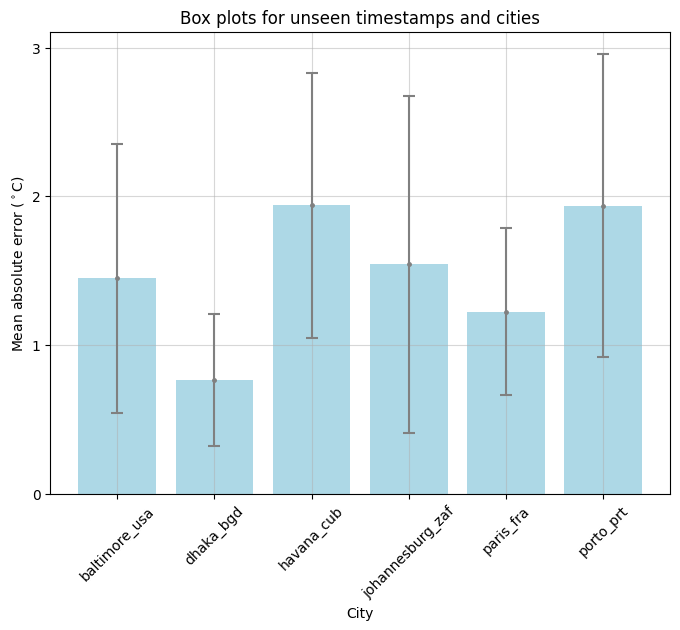

In [9]:
# Generate evaluation box plot
mdf = plot_box_plot(targets_path_patch, 
                    predictions_path_patch, 
                    results_path, 
                    save_plot=True)

These bar plots highlight that, overall, the model performance for unseen cities is on par with predictions for cities that the model was trained on, highlighting the generalisability of the model. This will be further demonstrated in the rest of the notebook patches/tiles from various seen and unseen cities are plottted and compared.

## Comparison plots
For the next step, the RGB composite image for the various patches/tiles for various cities are plottted along with the corresponding prediction, ground truth, error map, histogram and scatter plot to visualise the model performance. 

We will plot one prediction per city in the dataset:

Previously seen cities, but unseen timestamps:

1. dhaka_bgd.T46QBM.index_38_224.20221107.T102451.inputs.tif
2. johannesburg_zaf.T35JNM.index_10_224.20130426.T100951.inputs.tif
3. paris_fra.T31UDP.index_0_224.20190704.T114044.inputs.tif

Previously unseen cities and time:

4. baltimore_usa.T18SUJ.index_0_224.20131201.T104740.inputs.tif
5. havana_cub.T17QLF.index_5_224.20230227.T105716.inputs.tif
6. porto_prt.T29TNF.index_2_224.20180821.T111312.inputs.tif

In [10]:
patches = ['dhaka_bgd.T46QBM.index_38_224.20221107.T102451.inputs.tif',
           'johannesburg_zaf.T35JNM.index_10_224.20130426.T100951.inputs.tif',
           'paris_fra.T31UDP.index_0_224.20190704.T114044.inputs.tif', 
           'baltimore_usa.T18SUJ.index_0_224.20131201.T104740.inputs.tif',
           'havana_cub.T17QLF.index_5_224.20230227.T105716.inputs.tif',
           'porto_prt.T29TNF.index_2_224.20180821.T111312.inputs.tif']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0023034..25.577908].


Results directory exits!
Comparison plots directory exits!
Saving plot ..... ../data/results/comparison_plots/dhaka_bgd.T46QBM.index_38_224.20221107.T102451.inputs_comp_plot_enhance.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2858679..14.01755].


Saving plot ..... ../data/results/comparison_plots/johannesburg_zaf.T35JNM.index_10_224.20130426.T100951.inputs_comp_plot_enhance.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9392274..23.063915].


Saving plot ..... ../data/results/comparison_plots/paris_fra.T31UDP.index_0_224.20190704.T114044.inputs_comp_plot_enhance.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9057248..21.273928].


Saving plot ..... ../data/results/comparison_plots/baltimore_usa.T18SUJ.index_0_224.20131201.T104740.inputs_comp_plot_enhance.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1368861..11.568309].


Saving plot ..... ../data/results/comparison_plots/havana_cub.T17QLF.index_5_224.20230227.T105716.inputs_comp_plot_enhance.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2524734..15.164437].


Saving plot ..... ../data/results/comparison_plots/porto_prt.T29TNF.index_2_224.20180821.T111312.inputs_comp_plot_enhance.png


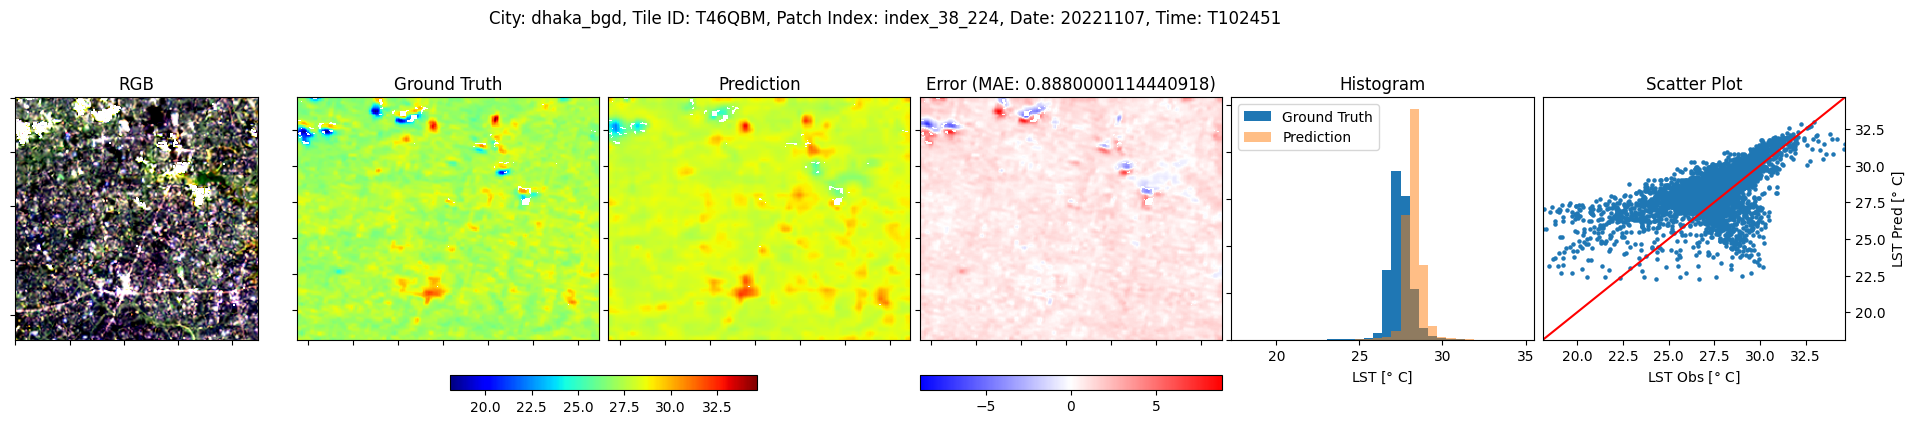

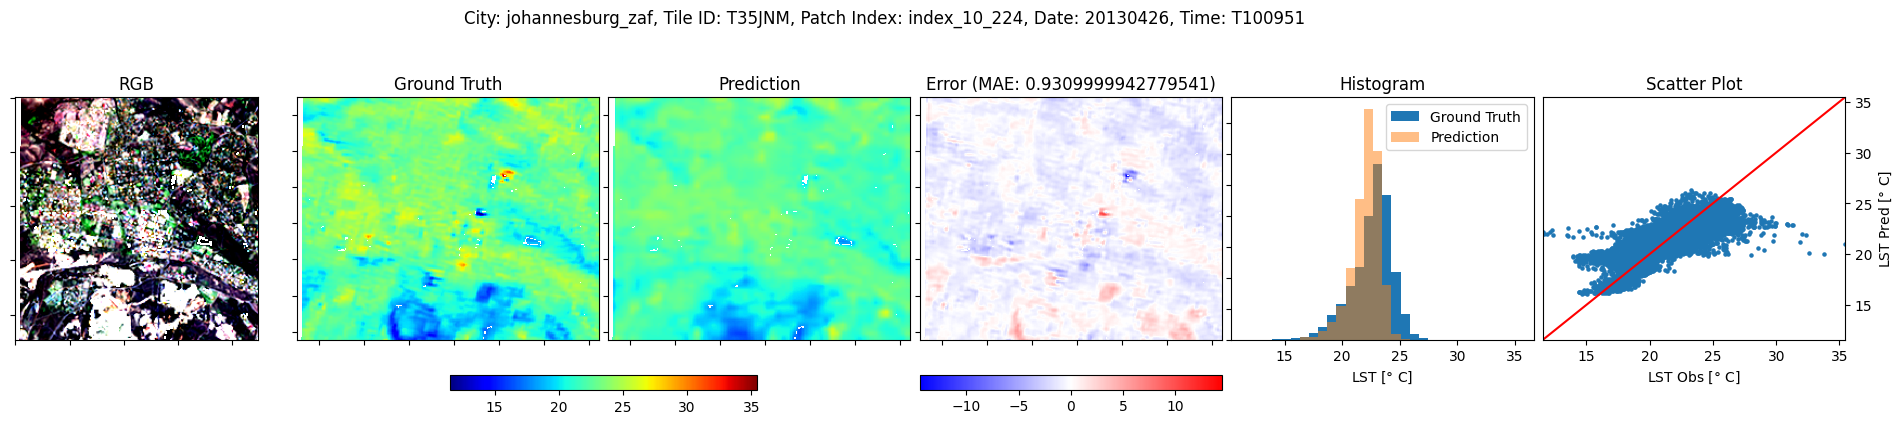

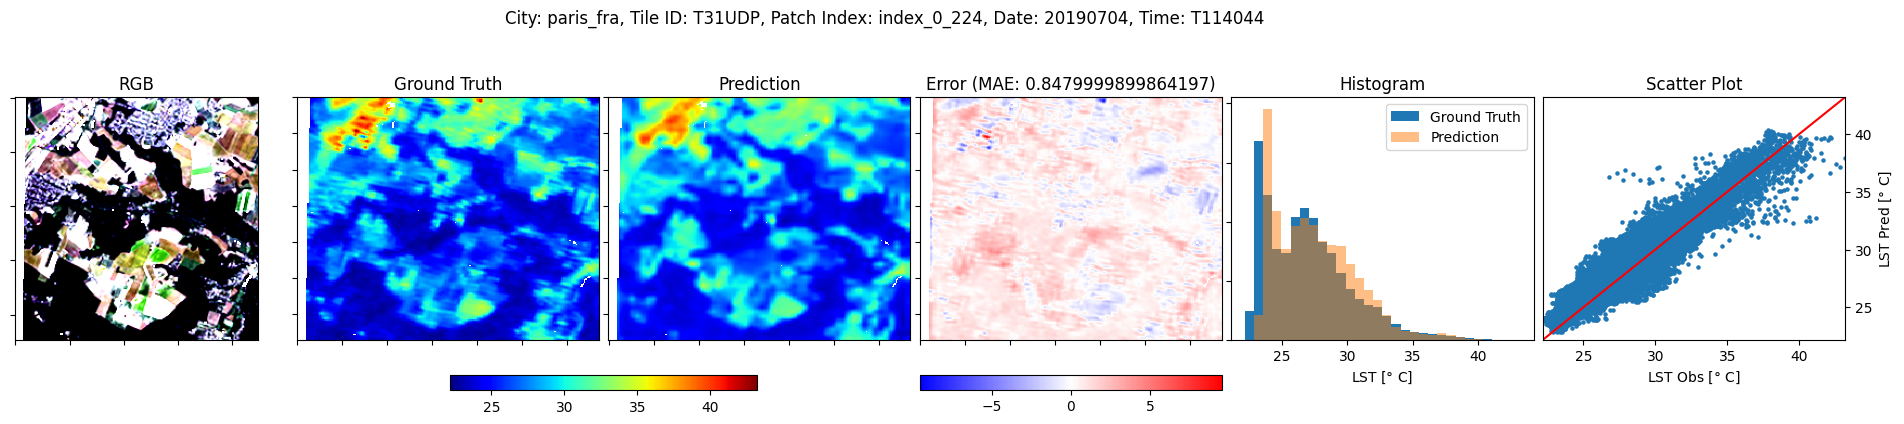

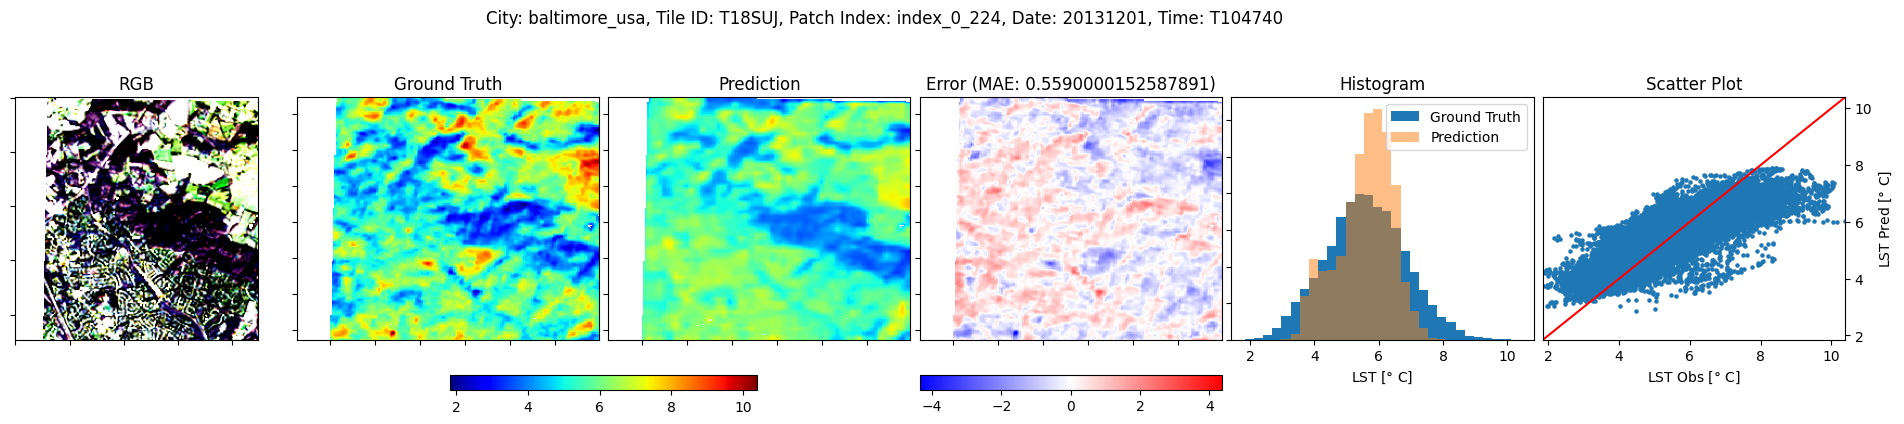

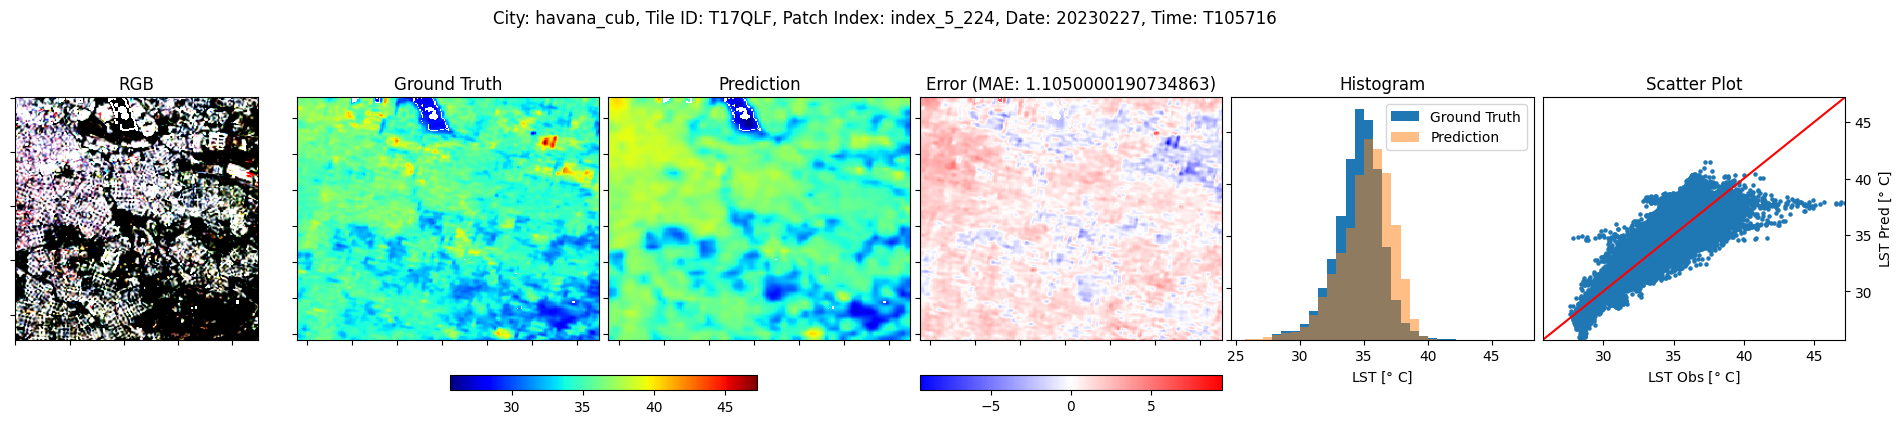

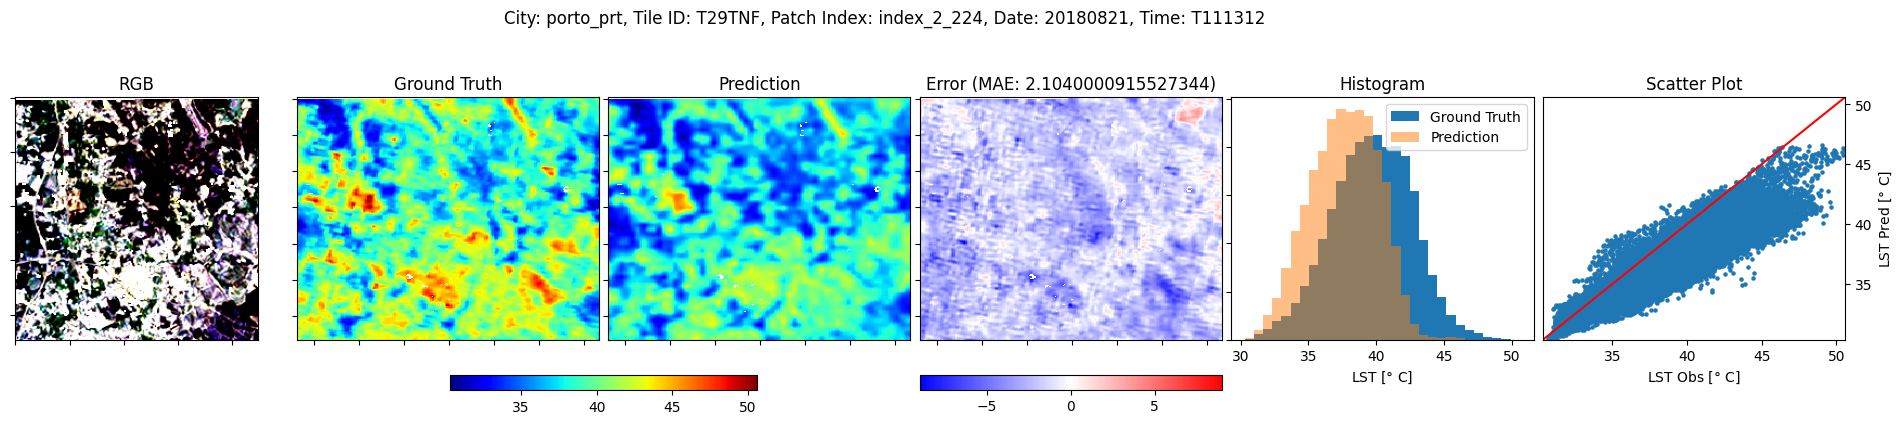

In [11]:
plot_rgb_lst_distribution_scatter(patches, 
                                  str(targets_path_patch), 
                                  str(predictions_path_patch), 
                                  str(results_path), 
                                  str(inputs_path_patch), 
                                  save_plot=True)

We hope this notebook provides you with the tools and understanding to drive innovation forward.